In [1]:
import cdsapi
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress

### Optional: Download data

In [4]:
# Download data from CDS
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "vertical_integral_of_eastward_water_vapour_flux",
        "vertical_integral_of_northward_water_vapour_flux",
        "vertically_integrated_moisture_divergence"
    ],
    "year": [
        "1980", "1981", "1982",
        "1983", "1984", "1985",
        "1986", "1987", "1988",
        "1989", "1990", "1991",
        "1992", "1993", "1994",
        "1995", "1996", "1997",
        "1998", "1999", "2000",
        "2001", "2002", "2003",
        "2004", "2005", "2006",
        "2007", "2008", "2009",
        "2010", "2011", "2012",
        "2013", "2014", "2015",
        "2016", "2017", "2018",
        "2019", "2020", "2021",
        "2022"
    ],
    "month": ["03", "04", "05"],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [90, -180, 0, 180]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-08-29 12:05:04,846 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-29 12:05:05,513 INFO Request ID is f41a69a8-9615-43b9-8b17-0846187d5525
2025-08-29 12:05:05,790 INFO status has been updated to accepted
2025-08-29 12:05:15,027 INFO status has been updated to running
2025-08-29 12:05:28,188 INFO status has been updated to accepted
2025-08-29 12:06:23,056 INFO status has been updated to running
2025-08-29 12:07:01,753 INFO status has been updated to successful


a455bc65264790c0202b43a076812868.zip:   0%|          | 0.00/304M [00:00<?, ?B/s]

'a455bc65264790c0202b43a076812868.zip'

### Analysis

In [ ]:
# Filter March/April and calculate trend at each grid cell
def monthly_trend(data, month):
    # Filter only the desired month
    month_data = data.sel(valid_time=data['valid_time'].dt.month == month)
    
    # Extract years as numeric array
    years = month_data['valid_time'].dt.year.values
    years_centered = years - years.mean()  # Center for numerical stability
    
    # Reshape years for polyfit: shape (N_time,)
    # Data shape: (time, ...) where ... are spatial dims
    
    # Move time axis to front and flatten spatial dims
    y = month_data.values
    orig_shape = y.shape[1:]  # all dims except time
    y_reshaped = y.reshape(len(years), -1)  # shape: (time, npoints)
    
    # Prepare array for slopes
    slopes = np.full(y_reshaped.shape[1], np.nan)
    
    # Loop over each spatial point (or use a vectorized approach)
    for i in range(y_reshaped.shape[1]):
        valid = np.isfinite(y_reshaped[:, i])
        if np.sum(valid) > 1:
            # Fit line: np.polyfit returns [slope, intercept]
            p = np.polyfit(years_centered[valid], y_reshaped[valid, i], 1)
            slopes[i] = p[0]
    
    # Reshape slopes back to spatial dims
    slopes = slopes.reshape(orig_shape)
    
    # Create new DataArray with same dims as spatial dims
    trend = xr.DataArray(slopes, dims=month_data.dims[1:], coords={dim: month_data.coords[dim] for dim in month_data.dims[1:]})
    
    return trend


# Apply to each variable for March and April
north_flux = xr.open_dataset('../data/moisture_flux.nc').viwvn
east_flux = xr.open_dataset('../data/moisture_flux.nc').viwve
divergence = xr.open_dataset('../data/moisture_divergence.nc').vimd

# Calculate trends for March (month = 3)
march_trend_north = monthly_trend(north_flux, 3)
march_trend_east = monthly_trend(east_flux, 3)
march_trend_div = monthly_trend(divergence, 3)

# April (month = 4)
april_trend_north = monthly_trend(north_flux, 4)
april_trend_east = monthly_trend(east_flux, 4)
april_trend_div = monthly_trend(divergence, 4)


In [15]:
# Save trends as NetCDF
march_trend_ds = xr.Dataset({
    "northward_flux_trend": march_trend_north,
    "eastward_flux_trend": march_trend_east,
    "divergence_trend": march_trend_div,
})
march_trend_ds.to_netcdf("march_flux_divergence_trend.nc")

april_trend_ds = xr.Dataset({
    "northward_flux_trend": april_trend_north,
    "eastward_flux_trend": april_trend_east,
    "divergence_trend": april_trend_div,
})
april_trend_ds.to_netcdf("april_flux_divergence_trend.nc")


In [170]:
# Load processed data
march_ds = xr.open_dataset("march_flux_divergence_trend.nc")
april_ds = xr.open_dataset("april_flux_divergence_trend.nc")

march_trend_east, march_trend_north, march_trend_div = march_ds.northward_flux_trend, march_ds.eastward_flux_trend, march_ds.divergence_trend
april_trend_east, april_trend_north, april_trend_div = april_ds.northward_flux_trend, april_ds.eastward_flux_trend, april_ds.divergence_trend

In [266]:
# Plot trends
def plot_quiver_with_contour(east, north, div, month_name):
    # Flip lat to go from south → north
    lat = east.latitude.values[::-1]
    lon = east.longitude.values

    # Create meshgrid in lon/lat
    Lon, Lat = np.meshgrid(lon, lat)
    
    # Plot
    fig, ax = plt.subplots(figsize=(18, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())  # Set lat/lon bounds
    ax.coastlines()
    ax.gridlines(alpha=0.3)
    
    # Contourf of divergence trend
    im = ax.contourf(
        lon, lat, div[::-1]*10,
        levels=np.linspace(-1.5, 1.5, 20),
        cmap="RdBu_r",
        transform=ccrs.PlateCarree()
    )
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=np.linspace(-1.5, 1.5, 7), shrink=0.5, aspect=50)
    cbar.set_label('Moisture Divergence (kg m$^{-2}$ decade$^{-1}$)')

    # Quiver of east/north moisture flux trends
    skip = 20
    U = east[::-1][::skip, ::skip].values * 10
    V = north[::-1][::skip, ::skip].values * 10
    X = Lon[::skip, ::skip]
    Y = Lat[::skip, ::skip]

    q = ax.quiver(
        X, Y, U, V,
        transform=ccrs.PlateCarree(),
        scale=500,
        width=0.0018,
        headlength=3,
        headwidth=2,
        headaxislength=3,
        color='black'
    )

    # Quiver key
    ax.quiverkey(
        q, 0.84, -0.1, 10,
        label="10 kg m$^{-1}$ s$^{-1}$ decade$^{-1}$",
        labelpos='E',
        coordinates='axes'
    )
    
    # Title and layout
    ax.set_title(f"{month_name} Moisture Flux & Divergence Trends (1980–2022)", fontsize=12)
    plt.savefig(f"../figures/{month_name}_Moisture_Flux_Divergence.png", dpi=300)
    plt.tight_layout()
    plt.show()


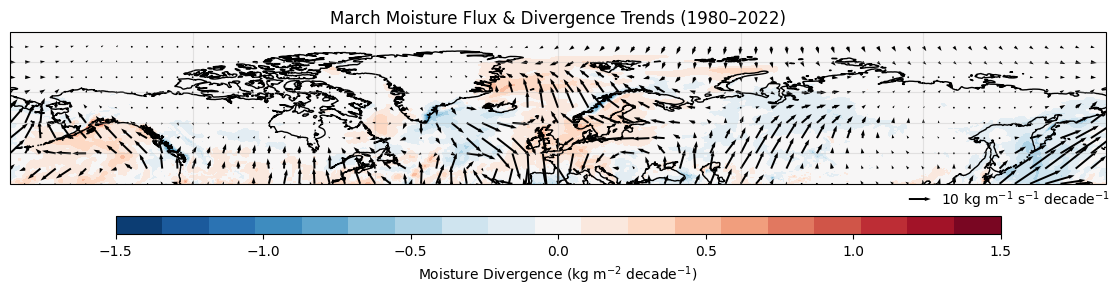

In [267]:
# Plot March
plot_quiver_with_contour(march_trend_east, march_trend_north, march_trend_div, "March")


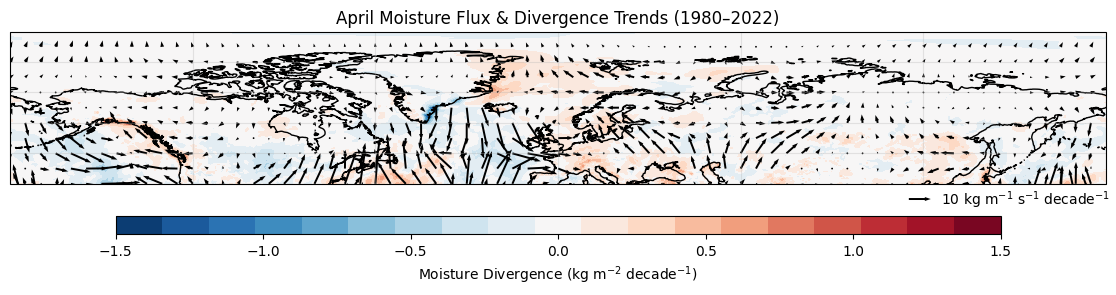

In [268]:
# Plot April
plot_quiver_with_contour(april_trend_east, april_trend_north, april_trend_div, "April")


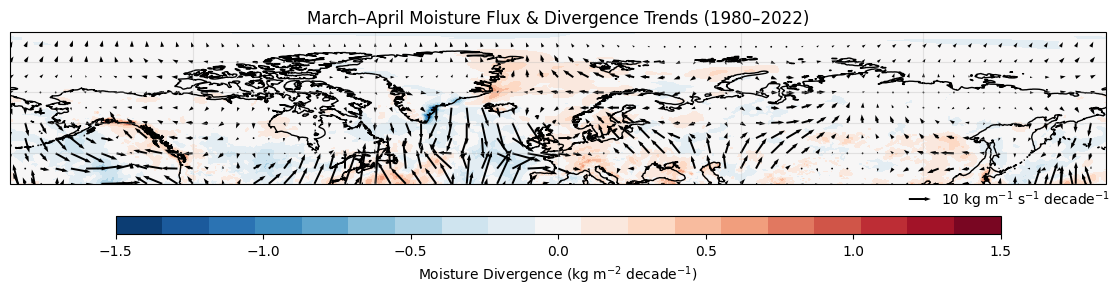

In [269]:
# Plot difference
diff_east = march_trend_east - april_trend_east
diff_north = march_trend_north - april_trend_north
diff_div = march_trend_div - april_trend_div

plot_quiver_with_contour(april_trend_east, april_trend_north, april_trend_div, "March–April")
